# Hands On Session: Autoencoders and Machine Learning
## By: Sabera Talukder

In [1]:
# All Imports - alphabetically ordered with shortcuts
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from scipy.io import loadmat
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

SEED = 38
np.random.seed(SEED)
_ = torch.random.manual_seed(SEED)

In [2]:
# !wget https://raw.githubusercontent.com/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/main/07_05_22_day1_overview/data/hypothalamus_calcium_imaging_remedios_et_al.mat?raw=true
# !mv hypothalamus_calcium_imaging_remedios_et_al.mat\?raw\=true hypothalamus_calcium_imaging_remedios_et_al.mat

# hypothalamus_data = loadmat('hypothalamus_calcium_imaging_remedios_et_al.mat')

path = '/Users/Albert/Desktop/sabera_chen/Chen_Institute_DataSAI_for_Neuroscience/07_08_22_day4_autoencoders_and_ML_introduction/data/'
hypothalamus_data = loadmat(path + 'hypothalamus_calcium_imaging_remedios_et_al.mat')

In [3]:
hypothalamus_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'attack_vector', 'neural_data', 'sex_vector'])

In [4]:
neural_data = hypothalamus_data['neural_data']
attack_vector = hypothalamus_data['attack_vector']
sex_vector = hypothalamus_data['sex_vector']

In [5]:
print(neural_data.shape)
print(attack_vector.shape)
print(sex_vector.shape)

(115, 18561)
(1, 18561)
(1, 18561)


In [6]:
neural_data_short = neural_data[:, 0:1000]

In [7]:
neural_data_short.shape

(115, 1000)

In [8]:
neural_data = neural_data_short

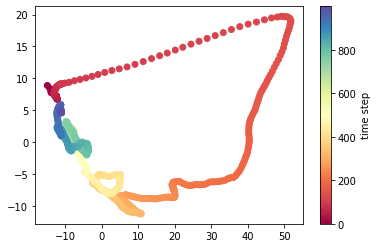

In [9]:
# Train PCA
pca_model_s_2 = PCA(n_components=2)
neural_pca_s_2 = pca_model_s_2.fit_transform(neural_data.T)

pc1 = neural_pca_s_2[:, 0]
pc2 = neural_pca_s_2[:, 1]

# Do the plotting for 2d
time_varying_color = np.arange(0, pc1.shape[0], 1)
_ = plt.scatter(pc1, pc2, c=time_varying_color, cmap='Spectral')
cbar = plt.colorbar()
cbar.set_label('time step')
_ = plt.show()

# auto encoder

In [10]:
class CustomDataset(Dataset):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        instance = self.data[idx, :]
        sample = {"data": instance}
        return sample

In [11]:
neural_data_float_tensor = torch.tensor(neural_data).float()

In [12]:
neural_data_float_tensor.shape

torch.Size([115, 1000])

In [13]:
neural_dataset_tensor = CustomDataset(neural_data_float_tensor)

In [14]:
neural_dataset_tensor.__getitem__(0)['data']

tensor([-8.8540e-01, -8.0569e-01, -7.3758e-01, -7.0009e-01, -6.9131e-01,
        -6.6413e-01, -6.1367e-01, -5.5790e-01, -5.0181e-01, -4.6700e-01,
        -4.4930e-01, -4.3775e-01, -4.3795e-01, -4.3753e-01, -4.3589e-01,
        -4.1899e-01, -4.0717e-01, -3.9056e-01, -3.8186e-01, -3.7554e-01,
        -3.7121e-01, -3.6905e-01, -3.6294e-01, -3.6343e-01, -3.6516e-01,
        -3.6748e-01, -3.7673e-01, -3.9276e-01, -4.0930e-01, -4.2900e-01,
        -4.5289e-01, -4.7699e-01, -4.9745e-01, -5.2045e-01, -5.4319e-01,
        -5.6527e-01, -5.8752e-01, -6.0831e-01, -6.2091e-01, -6.3850e-01,
        -6.5914e-01, -6.7365e-01, -6.9136e-01, -7.0999e-01, -7.3068e-01,
        -7.5290e-01, -7.6891e-01, -7.9035e-01, -8.1041e-01, -8.2733e-01,
        -8.4263e-01, -8.5976e-01, -8.6880e-01, -8.8017e-01, -8.9300e-01,
        -8.9602e-01, -9.0136e-01, -9.1004e-01, -9.1672e-01, -9.2680e-01,
        -9.3148e-01, -9.3886e-01, -9.3409e-01, -9.2807e-01, -9.2394e-01,
        -9.1938e-01, -9.1215e-01, -9.0859e-01, -9.0

In [15]:
train_size = int(np.floor(0.9 * len(neural_dataset_tensor)))
test_size = len(neural_dataset_tensor) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(neural_dataset_tensor, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=150, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=150, shuffle=True)

In [16]:
for idx, data in enumerate(train_loader):
    print(data['data'].shape)

torch.Size([103, 1000])


In [17]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Implementing a linear encoder (as opposed to a convolutional encoder, etc.).
        # This is composed of a linear layer followed by a Relu activation function, repeated several times.
        # We take data point from a dimension of 86086 (86 * 1001) down to a dimension of 10
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1000, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 4)
        )
          
        # Implementing a linear decoder (as opposed to a convolutional decoder, etc.).
        # Decoder is composed of a linear layer followed by a Relu activation function, repeated several times.
        # We take the embedding of size 10 and transform it back up to size 86086 (86 * 1001)/
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1000),
        )
  
    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction

In [18]:
epochs = 30
outputs = []
losses = []
validation_outputs = []
validation_losses = []

# Model Initialization
model = Autoencoder()
# Validation using Mean-Squared-Error MSE Loss function
loss_function = torch.nn.MSELoss()
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 1e-8)
# learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.98)

for epoch in range(epochs):
    # training on train set
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        # only pulling out the data not pulling out the labels. We don't actually need the labels for reconstruction!
        batch_data = batch['data']
        # this has dimension of batch size x 860086 
        flattened_batch_data = batch_data.reshape(-1, 1000)
        
        # Autoencoder Output
        reconstructed = model(flattened_batch_data)

        # Calculating the loss function
        loss = loss_function(reconstructed, flattened_batch_data)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(float(loss.detach()))
       
    # put model into evaluation mode
    model.eval()
    for validation_batch_idx, validation_batch in enumerate(test_loader):
        val_batch_data = validation_batch['data']
        validation_batch_data = val_batch_data.reshape(-1, 1000)
        # Autoencoder Output
        reconstructed_validation = model(validation_batch_data)
        # Calculating the loss function
        val_loss = loss_function(reconstructed_validation, validation_batch_data)
        validation_losses.append(float(val_loss.detach()))
    
    validation_outputs.append((epochs, validation_batch_data.detach().numpy(), reconstructed_validation.detach().numpy())) 
    outputs.append((epochs, flattened_batch_data.detach().numpy(), reconstructed.detach().numpy()))
    print('Finished Epoch: ', epoch)

Finished Epoch:  0
Finished Epoch:  1
Finished Epoch:  2
Finished Epoch:  3
Finished Epoch:  4
Finished Epoch:  5
Finished Epoch:  6
Finished Epoch:  7
Finished Epoch:  8
Finished Epoch:  9
Finished Epoch:  10
Finished Epoch:  11
Finished Epoch:  12
Finished Epoch:  13
Finished Epoch:  14
Finished Epoch:  15
Finished Epoch:  16
Finished Epoch:  17
Finished Epoch:  18
Finished Epoch:  19
Finished Epoch:  20
Finished Epoch:  21
Finished Epoch:  22
Finished Epoch:  23
Finished Epoch:  24
Finished Epoch:  25
Finished Epoch:  26
Finished Epoch:  27
Finished Epoch:  28
Finished Epoch:  29


In [19]:
len(outputs)

30

In [20]:
outputs[0][-1].shape

(103, 1000)

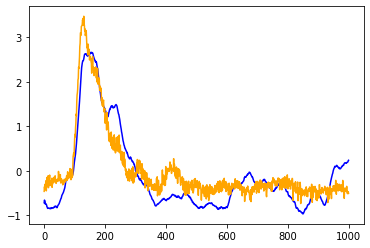

In [21]:
epoch_idx = -1
neuron_idx = 10
_ = plt.plot(outputs[epoch_idx][1][neuron_idx, :], color='blue')
_ = plt.plot(outputs[epoch_idx][2][neuron_idx, :], color='orange')

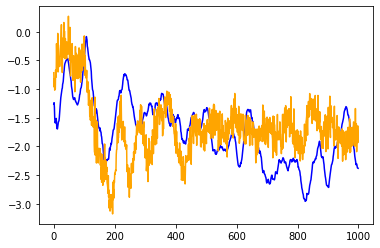

In [22]:
epoch_idx = -1
neuron_idx = 80
_ = plt.plot(outputs[epoch_idx][1][neuron_idx, :], color='blue')
_ = plt.plot(outputs[epoch_idx][2][neuron_idx, :], color='orange')

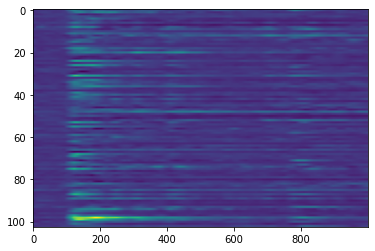

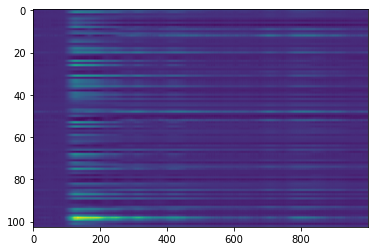

In [23]:
_ = plt.imshow(outputs[-1][1], aspect='auto')
_ = plt.show()
_ = plt.imshow(outputs[-1][2], aspect='auto')

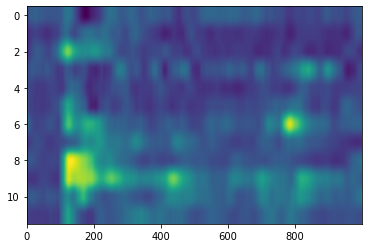

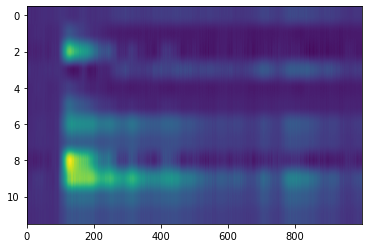

In [24]:
_ = plt.imshow(validation_outputs[-1][1], aspect='auto')
_ = plt.show()
_ = plt.imshow(validation_outputs[-1][2], aspect='auto')

30


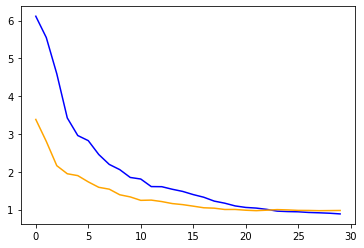

In [25]:
print(len(losses))
from_this = 0
_ = plt.plot(losses[from_this:], color='blue')
_ = plt.plot(validation_losses[from_this:], color='orange')
# _ = plt.ylim(2.5,2000)

# Visualize with PCA

In [26]:
train_original_data = outputs[-1][1]
train_reconstructed_data = outputs[-1][2]

test_original_data = validation_outputs[-1][1]
test_reconstructed_data = validation_outputs[-1][2]

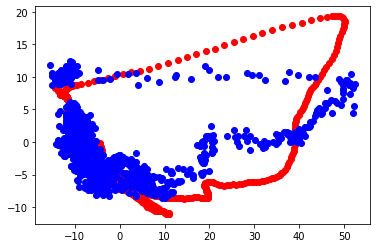

In [27]:
# Train PCA
pca_model_train_od = PCA(n_components=2)
neural_pca_train_od = pca_model_train_od.fit_transform(train_original_data.T)

pca_model_train_rd = PCA(n_components=2)
neural_pca_train_rd = pca_model_train_rd.fit_transform(train_reconstructed_data.T)

# Plot original train data and train reconstructions
_ = plt.scatter(neural_pca_train_od[:, 0], neural_pca_train_od[:, 1], color='red')
_ = plt.scatter(neural_pca_train_rd[:, 0], neural_pca_train_rd[:, 1], color='blue')

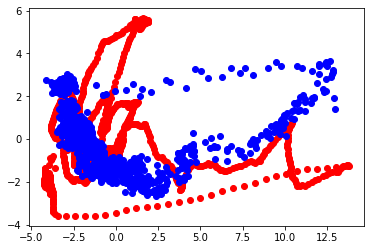

In [28]:
# Test PCA
pca_model_test_od = PCA(n_components=2)
neural_pca_test_od = pca_model_test_od.fit_transform(test_original_data.T)

pca_model_test_rd = PCA(n_components=2)
neural_pca_test_rd = pca_model_test_rd.fit_transform(test_reconstructed_data.T)

# Plot original train data and train reconstructions
_ = plt.scatter(neural_pca_test_od[:, 0], neural_pca_test_od[:, 1], color='red')
_ = plt.scatter(neural_pca_test_rd[:, 0], neural_pca_test_rd[:, 1], color='blue')